In [ ]:
import pandas as pd

In [ ]:
!pip install -q kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"theraghavjuneja","key":"d24836b84ec39cad87a34aef68ea0283"}'}

In [ ]:
import os
import zipfile


os.makedirs('/root/.kaggle', exist_ok=True)


!mv kaggle.json /root/.kaggle/


!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

100%|██████████| 7.43G/7.43G [01:16<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import timm
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [ ]:
import os
os.listdir('/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/')

['Evaluation_Set', 'Test_Set', 'Training_Set']

In [ ]:
# Training
train_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Training_Set/Training_Set/Training'
train_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Training_Set/Training_Set/RFMiD_Training_Labels.csv'

# Validation
val_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Evaluation_Set/Evaluation_Set/Validation'
val_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'

# Test
test_dir = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Test_Set/Test_Set/Test'
test_labels_path = '/root/.cache/kagglehub/datasets/andrewmvd/retinal-disease-classification/versions/1/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'


In [ ]:
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

In [ ]:
# Print dataset shapes
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1920, 47)
Validation labels shape: (640, 47)
Test labels shape: (640, 47)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Resizing(224, 224),                                 # Resize to 224x224
    layers.RandomFlip("horizontal"),                           # Random horizontal flip
    layers.RandomRotation(0.1),                                # Rotate by ±10% of 360° (~36°)
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),    # Random zoom
    layers.RandomContrast(0.2),                                # Random contrast adjustment
    layers.RandomTranslation(0.1, 0.1),                         # Random shifts (10% height & width)
])


In [ ]:
import tensorflow as tf
import pandas as pd
import os

# Data augmentation layer from previous step
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

def load_image_and_label(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # scale to [0,1]
    image = data_augmentation(image)
    return image, tf.cast(label, tf.float32)

def create_tf_dataset(image_dir, labels_df, batch_size=32, shuffle=True):
    image_paths = [os.path.join(image_dir, f"{img_id}.png") for img_id in labels_df['ID']]
    labels = labels_df['Disease_Risk'].values

    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    image_label_ds = path_ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        image_label_ds = image_label_ds.shuffle(buffer_size=len(labels_df))

    return image_label_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Hub not available, using simple ViT implementation


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │    590,592 │ input_layer_2[0]… │
│                     │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 768)  │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 768)  │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 768)  │  2,362,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 768)  │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 768)  │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 768)  │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 768)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 768)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 768)  │      1,536 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 768)  │  2,362,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 768)  │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 768)  │      1,536 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 3072) │  2,362,368 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 768)  │  2,360,064 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 196, 768)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 196, 768)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 86,104,577 (328.46 MB)

 Trainable params: 86,104,577 (328.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6262 - loss: 0.7250
Epoch 1: val_loss improved from inf to 0.50892, saving model to best_vit_model.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.6275 - loss: 0.7232 - val_accuracy: 0.7906 - val_loss: 0.5089 - learning_rate: 1.0000e-04
Epoch 2/18
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7505 - loss: 0.5484
Epoch 2: val_loss did not improve from 0.50892
60/60 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.7505 - loss: 0.5483 - val_accuracy: 0.7906 - val_loss: 0.5199 - learning_rate: 1.0000e-04
Epoch 3/18
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7992 - loss: 0.5064
Epoch 3: val_loss did not improve from 0.50892
60/60 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.7987 - loss: 0.5069 - val_accuracy: 0.7906 - val_loss: 0.5218 - learning_rate: 1.0000e-04
Epoch 4/18
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8052 - loss: 0.5028
Epoch 4: val_loss did not improve from 0.50892
60/60 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.8048 - loss: 0.5031 - val_accuracy: 0.7906 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 5/18
60/60 ━━━━━━━━━━━━━━━━━

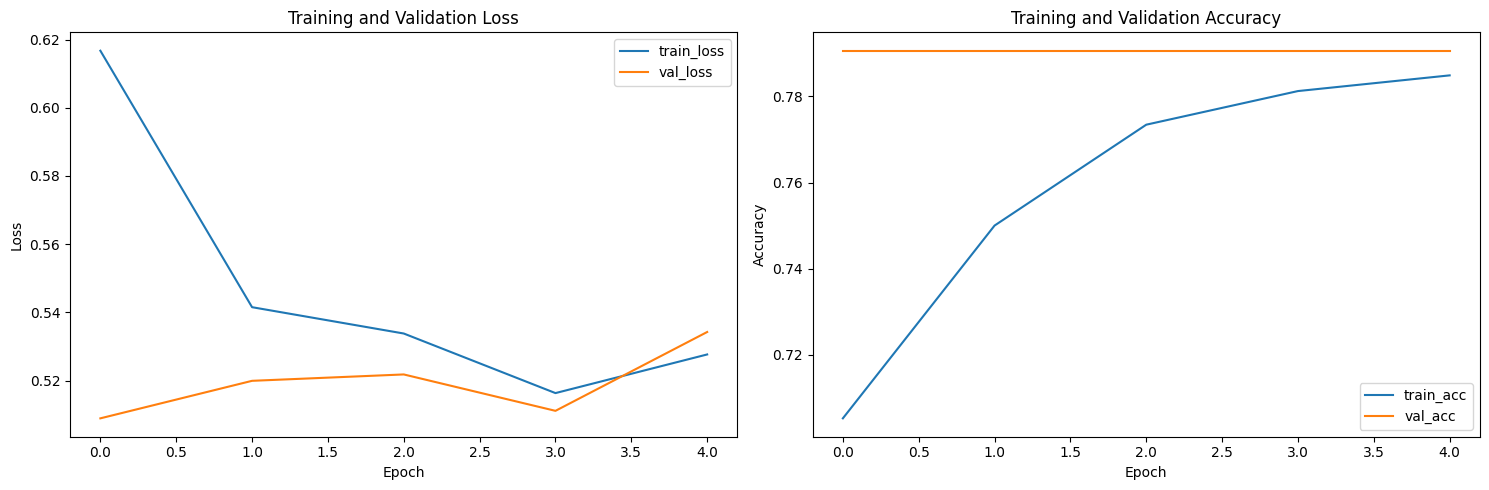

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9271 - loss: 0.3449
Test Loss: 0.5128, Test Accuracy: 0.7906
20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
Training and evaluation complete!


In [ ]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow_hub as hub

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Data Augmentation using TensorFlow's data augmentation layers
def get_data_augmentation():
    data_augmentation = tf.keras.Sequential([
        layers.Resizing(224, 224),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),  # ~18 degrees
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        # TensorFlow doesn't have direct equivalents for some PyTorch augmentations
        # but we can approximate them
    ])
    return data_augmentation

# Normalization values (same as the PyTorch code)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def normalize_img(image, label):
    # Convert to float and scale to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Normalize with ImageNet mean and std
    image = (image - MEAN) / STD
    return image, label

# Create a data loading function equivalent to the PyTorch RetinalDataset
class RetinalDataGenerator:
    def __init__(self, image_dir, labels_df, batch_size=32, is_training=True):
        self.image_dir = image_dir
        self.labels_df = labels_df
        self.batch_size = batch_size
        self.is_training = is_training
        self.data_augmentation = get_data_augmentation()

    def create_dataset(self):
        # Create a list of image paths and labels
        image_paths = [os.path.join(self.image_dir, f"{row['ID']}.png")
                      for _, row in self.labels_df.iterrows()]
        labels = self.labels_df['Disease_Risk'].values.astype(np.float32)

        # Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

        # Load and preprocess images
        dataset = dataset.map(self._load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

        # Apply data augmentation only during training
        if self.is_training:
            dataset = dataset.map(
                lambda x, y: (self.data_augmentation(x), y),
                num_parallel_calls=tf.data.AUTOTUNE
            )

        # Normalize images
        dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

        # Batch and prefetch
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        if self.is_training:
            dataset = dataset.shuffle(buffer_size=len(image_paths))

        return dataset

    def _load_and_preprocess(self, img_path, label):
        # Load the image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=3)

        # Resize to target size
        img = tf.image.resize(img, [224, 224])

        return img, label

# Create a custom ViT model with TensorFlow
def create_vit_model():
    # Option 1: Use TensorFlow Hub's ViT model (base version)
    vit_url = "https://tfhub.dev/google/vit_b16_224/1"  # ViT-Base/16 pre-trained on ImageNet

    # Create input layer
    inputs = layers.Input(shape=(224, 224, 3))

    # Load the pre-trained ViT model
    vit_base = hub.KerasLayer(vit_url, trainable=True)

    # Apply the model to our input
    x = vit_base(inputs)

    # Add custom layers for binary classification
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1)(x)  # No activation for BCEWithLogitsLoss equivalent

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

# Alternative: Implement a simpler ViT from scratch if TF Hub is not available
def create_simple_vit_model():
    # Create a simpler version of a ViT-like model
    inputs = layers.Input(shape=(224, 224, 3))

    # Patch extraction and embedding
    x = layers.Conv2D(768, kernel_size=16, strides=16, padding="valid")(inputs)
    patch_size = x.shape[1] * x.shape[2]
    x = layers.Reshape((patch_size, 768))(x)

    # Position embeddings
    position_embedding = layers.Embedding(
        input_dim=patch_size, output_dim=768
    )
    positions = tf.range(start=0, limit=patch_size, delta=1)
    x = x + position_embedding(positions)

    # Transformer blocks
    for _ in range(12):  # 12 transformer blocks like in ViT-Base
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=12, key_dim=64
        )(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # MLP
        mlp = layers.Dense(3072, activation="gelu")(x)
        mlp = layers.Dense(768)(mlp)
        mlp = layers.Dropout(0.1)(mlp)

        x = layers.Add()([x, mlp])
        x = layers.LayerNormalization(epsilon=1e-6)(x)


    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1)(x)  # No activation for BCEWithLogitsLoss equivalent

    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)

    return model


def train_model(model, train_dataset, val_dataset, epochs=18, patience=4, initial_lr=1e-4):
    # Compile the model with binary crossentropy loss (equivalent to BCEWithLogitsLoss)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr, weight_decay=1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
        ]
    )


    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        'best_vit_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )


    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )


    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )


    return history

def evaluate_model(model, test_dataset):

    results = model.evaluate(test_dataset, verbose=1)
    print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}")


    predictions = model.predict(test_dataset)

    return predictions, results


def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='train_loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()


    ax2.plot(history.history['accuracy'], label='train_acc')
    ax2.plot(history.history['val_accuracy'], label='val_acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Main execution
if __name__ == "__main__":

    try:
        import tensorflow_hub as hub
    except ImportError:
        import subprocess
        print("Installing tensorflow-hub...")
        subprocess.check_call(["pip", "install", "tensorflow-hub"])
        import tensorflow_hub as hub


    train_data = RetinalDataGenerator(train_dir, train_labels, batch_size=32, is_training=True).create_dataset()
    val_data = RetinalDataGenerator(val_dir, val_labels, batch_size=32, is_training=False).create_dataset()
    test_data = RetinalDataGenerator(test_dir, test_labels, batch_size=32, is_training=False).create_dataset()


    try:

        vit_model = create_vit_model()
        print("Using TensorFlow Hub ViT model")
    except:

        print("TensorFlow Hub not available, using simple ViT implementation")
        vit_model = create_simple_vit_model()


    vit_model.summary()

    # Train the model
    history = train_model(
        vit_model,
        train_data,
        val_data,
        epochs=18,
        patience=4
    )


    plot_training_history(history)

    test_predictions, test_results = evaluate_model(vit_model, test_data)

    print("Training and evaluation complete!")